# Library Import

In [1]:
#-- Basics Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 

#-- Warnings OFF
from warnings import simplefilter

#-- Autocorrelação
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
#from dateutil.parser import parse

#-- Scaler
from sklearn.preprocessing import MinMaxScaler

simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")

%matplotlib inline

# Function definition

In [2]:
def df_transform(path, name):
  '''
    O conjunto de dados em relação aos rios é composto por duas séries
    históricas, cada uma representa a vazão média em [m^3/ s] de um
    determinado mês das usinas hidroelétricas de Furnas e Camargos. Estas
    séries históricas apresentam alta correlação que pode ser explicada pelo
    fato de que ambas as usinas estão situadas no Rio Grande, na bacia do
    Rio Paraná. Os dados são de 82 anos do histórico de operação dessas duas
    usinas hidroelétricas, totalizando 984 amostras mensais desde janeiro de
    1931 até dezembro de 2012, adquiridos pela ONS (Operador Nacional do
    Sistema Elétrico).
  '''

  ## Sequence list of data
  #Camargos: https://raw.githubusercontent.com/thiagolopes97/E-TUNI_NARMAX_RIVER/main/Datasets/Rio%2001%20Camargos.txt
  #Furnas: https://raw.githubusercontent.com/thiagolopes97/E-TUNI_NARMAX_RIVER/main/Datasets/Rio%2002%20Furnas.txt

  df = pd.read_csv(path,sep='\t',header=None)
  df.columns = ['01','02','03',
                '04','05','06',
                '07','08','09',
                '10','11','12']
  df_melted = pd.melt(df)
  

  lista_aux = []
  for i in df_melted.variable.unique():
    for year in range(1931,2013):
      lista_aux.append(year)

  df_melted['Year'] = lista_aux
  df_melted['Date'] = pd.to_datetime(df_melted.variable.astype(str) + '/' + df_melted['Year'].astype(str),format='%m/%Y')
  df_melted.sort_values('Date',inplace=True)
  df_melted['Name'] = name
  df_melted.reset_index(inplace=True,drop=True)

  return df_melted


In [3]:
def Hurst(obj_sample, name):
  # Hurst Expoent calculation
  Size_final = []
  RS_final = []
  size_max = len(obj_sample)
  i = 1
  while True:
    middle_process = []
    for obj_sample_sized in np.array_split(obj_sample, i,):
      actual_size = len(obj_sample_sized)
      mean = obj_sample_sized.mean()
      std = obj_sample_sized.std()
      Vk = (obj_sample_sized - mean).cumsum()
      range = Vk.max() - Vk.min()
      RS = range/std
      middle_process.append(RS)

    Size_final.append(len(Vk))
    RS_final.append(np.array(middle_process).mean())
    i = i*2
    if actual_size < 8:
      break

  X_final = np.log10(Size_final)
  Y_final = np.log10(RS_final)
  z = np.polyfit(X_final, Y_final, 1)

  print(f'Coeficiente de Hurst = {round(z[0],4)}')
  plt.scatter(X_final,Y_final, label='Pontos calculados',marker = 'x',c='red')
  plt.plot(X_final,z[0]*X_final + z[1],label='Regressão',linestyle = '--',c='black')
  plt.xlabel('log2(N)')
  plt.ylabel('log2(R/S)')
  plt.legend()
  plt.savefig(f'hurst_calc_{name}.png', format='png')

In [4]:
camargos = df_transform('https://raw.githubusercontent.com/thiagolopes97/E-TUNI_NARMAX_RIVER/main/Datasets/Rio%2001%20Camargos.txt',
                        'Camargos')

furnas = df_transform('https://raw.githubusercontent.com/thiagolopes97/E-TUNI_NARMAX_RIVER/main/Datasets/Rio%2002%20Furnas.txt',
                        'Furnas')

In [5]:
camargos.head()

,variable,value,Year,Date,Name
0,01,178,1931,1931-01-01,Camargos
1,02,371,1931,1931-02-01,Camargos
2,03,326,1931,1931-03-01,Camargos
3,04,479,1931,1931-04-01,Camargos
4,05,332,1931,1931-05-01,Camargos


In [6]:
furnas.head()

,variable,value,Year,Date,Name
0,01,1476,1931,1931-01-01,Furnas
1,02,2964,1931,1931-02-01,Furnas
2,03,2167,1931,1931-03-01,Furnas
3,04,1585,1931,1931-04-01,Furnas
4,05,1254,1931,1931-05-01,Furnas


In [7]:
df = camargos[['Date','value']]
df.columns = ['Date','Camargos']
df['Date'] = pd.to_datetime(df['Date'])
df['Furnas'] = furnas['value']
df.index = df['Date']
df.head()

<ipython-input-7-e8b44fc39902>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-7-e8b44fc39902>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Furnas'] = furnas['value']


,Date,Camargos,Furnas
Date,,,
1931-01-01,1931-01-01,178,1476
1931-02-01,1931-02-01,371,2964
1931-03-01,1931-03-01,326,2167
1931-04-01,1931-04-01,479,1585
1931-05-01,1931-05-01,332,1254


In [8]:
scaler = MinMaxScaler()
df[['Camargos_norm', 'Furnas_norm']] = scaler.fit_transform(df[['Camargos', 'Furnas']])
df.head()

<ipython-input-8-6ac6e02ab2ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Camargos_norm', 'Furnas_norm']] = scaler.fit_transform(df[['Camargos', 'Furnas']])


,Date,Camargos,Furnas,Camargos_norm,Furnas_norm
Date,,,,,
1931-01-01,1931-01-01,178,1476,0.265683,0.358007
1931-02-01,1931-02-01,371,2964,0.621771,0.776808
1931-03-01,1931-03-01,326,2167,0.538745,0.552491
1931-04-01,1931-04-01,479,1585,0.821033,0.388686
1931-05-01,1931-05-01,332,1254,0.549815,0.295525


# Dados históricos

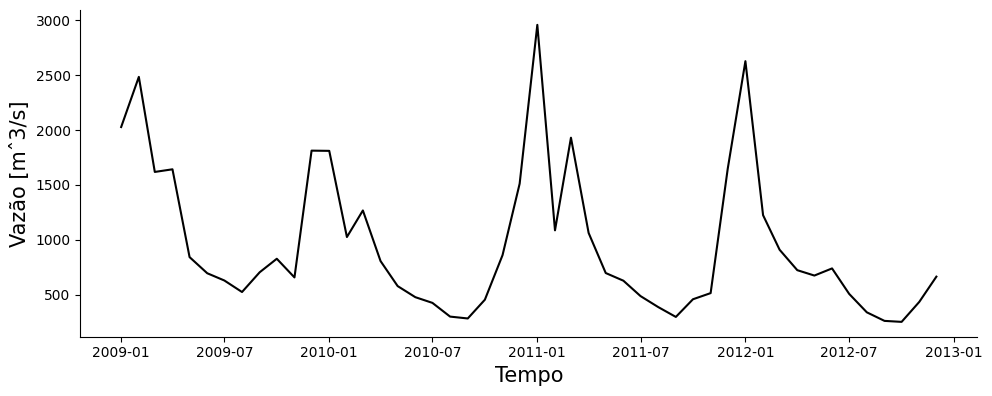

In [9]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df[df.Date >= '2009-01-01'],x='Date',y='Furnas', color = 'k')
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('Vazão [mˆ3/s]', size=15)
plt.xlabel('Tempo', size=15)
plt.savefig(f'Camargos Flow River Time Series.png', format='png')
plt.show();


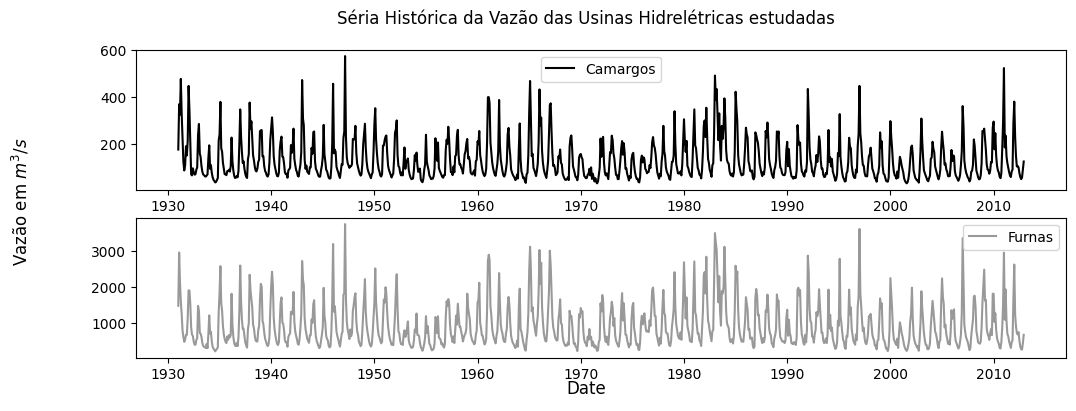

In [10]:
figure, axes = plt.subplots(2, 1, figsize=(12,4))
figure.suptitle(f'Séria Histórica da Vazão das Usinas Hidrelétricas estudadas')
figure.supylabel('Vazão em $m^3/s$')
figure.supxlabel('Date')
fig0 = sns.lineplot(ax=axes[0],data=df,x='Date',y='Camargos', color = 'k', label="Camargos")


fig1 = sns.lineplot(ax=axes[1],data=df,x='Date',y='Furnas', color = '#999', label="Furnas")

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_xlabel(' ')
axes[1].set_xlabel(' ')

plt.legend()
plt.savefig(f'Série histórica.png', format='png')
plt.show()

  


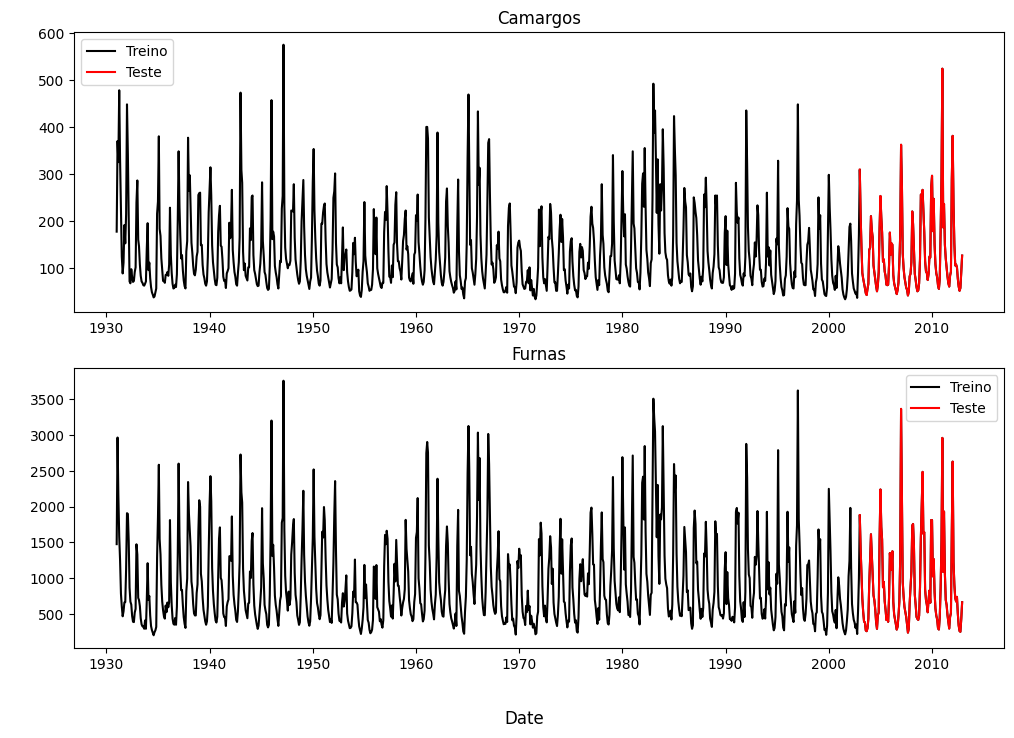

In [11]:
figure, axes = plt.subplots(2, 1, figsize=(12,8))

figure.supxlabel('Date')
fig0 = sns.lineplot(ax=axes[0],data=df,x='Date',y='Camargos', color = 'k', label='Treino')
fig0 = sns.lineplot(ax=axes[0],data=df.tail(12*10),x='Date',y='Camargos', color = 'r', label="Teste")

fig1 = sns.lineplot(ax=axes[1],data=df,x='Date',y='Furnas', color = 'k', label="Treino")
fig1 = sns.lineplot(ax=axes[1],data=df.tail(12*10),x='Date',y='Furnas', color = 'r', label="Teste")

axes[0].set_title('Camargos')
axes[1].set_title('Furnas')

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_xlabel(' ')
axes[1].set_xlabel(' ')

plt.legend()
plt.savefig(f'Divisão Treino-Teste.png', format='png')
plt.show()

  


# Correlação - Simples

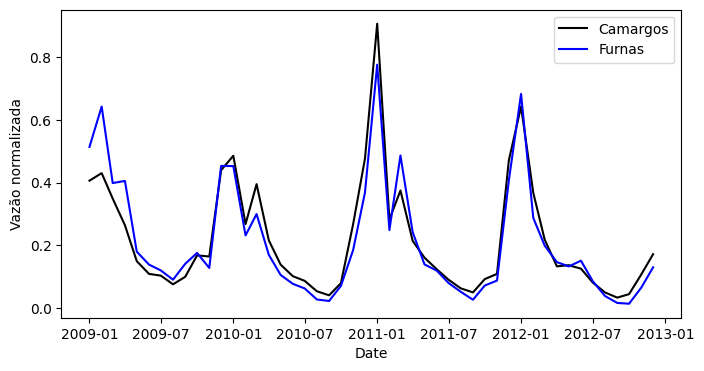

In [12]:
figure, axes = plt.subplots(1, 1, figsize=(8,4))

fig0 = sns.lineplot(data=df[df.Date >= '2009-01-01'],x='Date',y='Camargos_norm', color = 'k',linestyle='-', label="Camargos")
fig1 = sns.lineplot(data=df[df.Date >= '2009-01-01'],x='Date',y='Furnas_norm', color = 'b', linestyle='-', label="Furnas")
plt.legend()
plt.ylabel('Vazão normalizada')
plt.savefig(f'Dados normalizados.png', format='png')
plt.show()


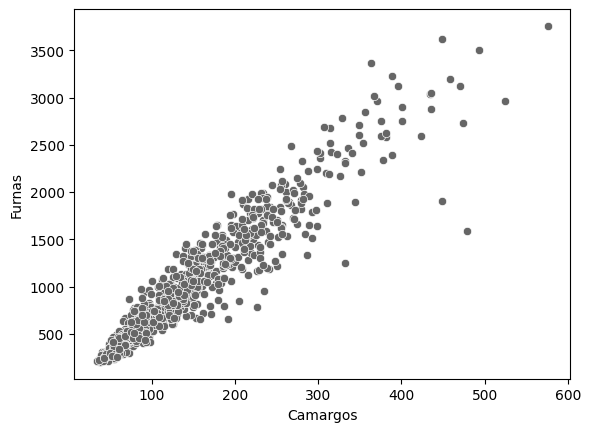

In [13]:
plt.figure()
sns.scatterplot(data=df,x='Camargos',y='Furnas', color = '#666666')
plt.savefig(f'Dispersão histórica.png', format='png')
plt.show()

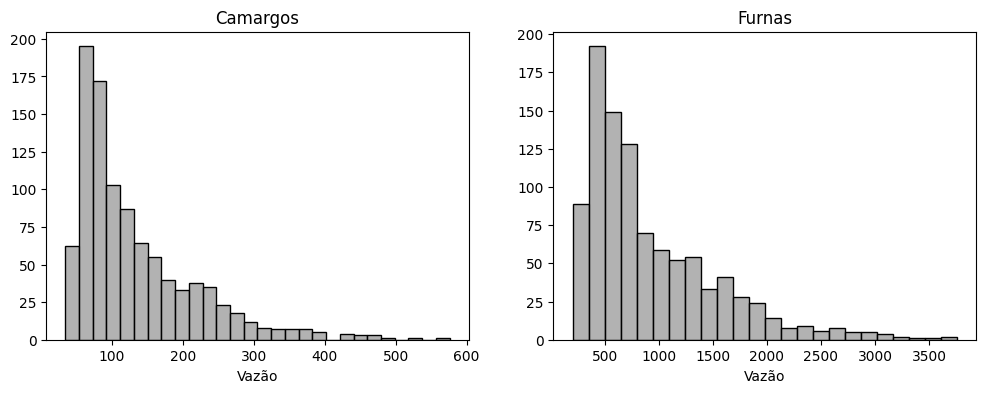

In [14]:
figure, axes = plt.subplots(1, 2, figsize=(12,4))
fig0 = sns.histplot(ax=axes[0],data=df,x='Camargos', color = '#999', label="Camargos")
fig1 = sns.histplot(ax=axes[1],data=df,x='Furnas', color = '#999', label="Furnas")

axes[1].set_title('Furnas')
axes[0].set_title('Camargos')

axes[0].set_ylabel('')
axes[1].set_ylabel('')


axes[0].set_xlabel('Vazão')
axes[1].set_xlabel('Vazão')
plt.savefig(f'Distribuição Séries.png', format='png')
plt.show()

  


In [15]:
df.describe(percentiles=[0.1,0.8,0.9,0.99])

,Camargos,Furnas,Camargos_norm,Furnas_norm
count,984.000000,984.000000,984.000000,984.000000
mean,132.963415,926.026423,0.182589,0.203216
std,84.746986,615.739071,0.156360,0.173301
min,34.000000,204.000000,0.000000,0.000000
10%,58.000000,362.000000,0.044280,0.044469
50%,102.500000,705.000000,0.126384,0.141008
80%,194.400000,1364.400000,0.295941,0.326597
90%,249.400000,1809.500000,0.397417,0.451872
99%,436.000000,3017.230000,0.741697,0.791790
max,576.000000,3757.000000,1.000000,1.000000


In [16]:
df.corr()

,Camargos,Furnas,Camargos_norm,Furnas_norm
Camargos,1.000000,0.953012,1.000000,0.953012
Furnas,0.953012,1.000000,0.953012,1.000000
Camargos_norm,1.000000,0.953012,1.000000,0.953012
Furnas_norm,0.953012,1.000000,0.953012,1.000000


# Autocorrelação

In [17]:
time_point = '2000-01-01'
period = 12

## Camargos

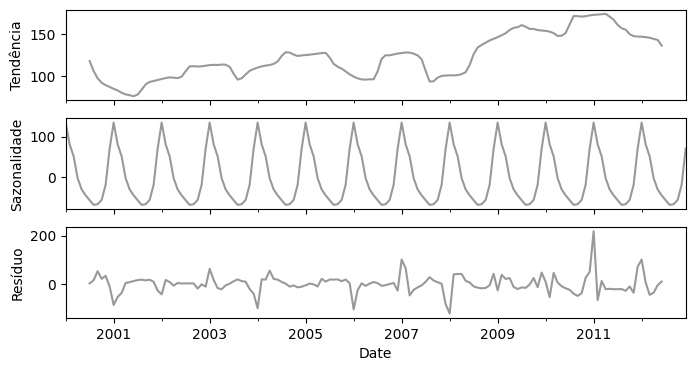

In [18]:
result=seasonal_decompose(df[df['Date'] >= time_point]['Camargos'], model='aditive', period=period)

fig, axes = plt.subplots(3, 1,figsize=(8,4), sharex=True)

result.trend.plot(ax=axes[0], legend=False, color='#999')
axes[0].set_ylabel('Tendência')
result.seasonal.plot(ax=axes[1], legend=False, color='#999')
axes[1].set_ylabel('Sazonalidade')
result.resid.plot(ax=axes[2], legend=False, color='#999')
axes[2].set_ylabel('Resíduo')

plt.savefig(f'Components Time Series - Camargos.png', format='png')
plt.show()

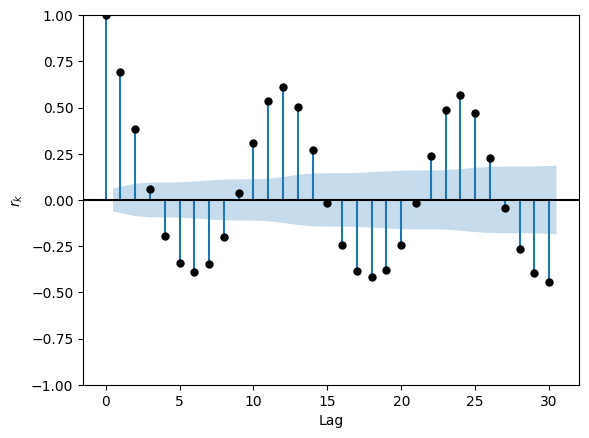

In [19]:
plot_acf(x=df['Camargos'], lags=30, color= 'k')
plt.ylabel(f'$r_k$')
plt.xlabel('Lag')
plt.title('')
plt.savefig(f'Autocorrelation - Camargos.png', format='png')
plt.show()

## Furnas

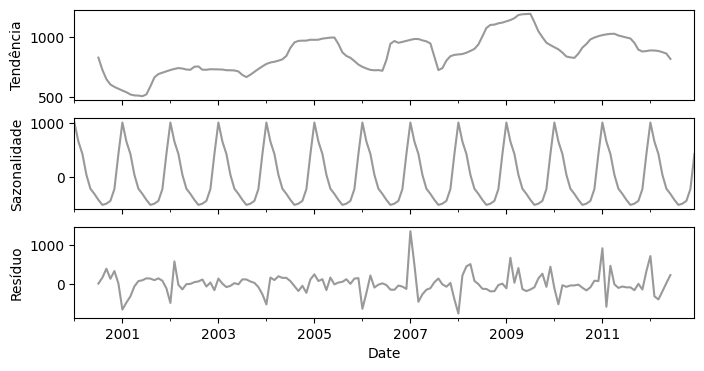

In [20]:
result=seasonal_decompose(df[df['Date'] >= time_point]['Furnas'], model='aditive', period=period)

fig, axes = plt.subplots(3, 1,figsize=(8,4), sharex=True)

result.trend.plot(ax=axes[0], legend=False, color='#999')
axes[0].set_ylabel('Tendência')
result.seasonal.plot(ax=axes[1], legend=False, color='#999')
axes[1].set_ylabel('Sazonalidade')
result.resid.plot(ax=axes[2], legend=False, color='#999')
axes[2].set_ylabel('Resíduo')

plt.savefig(f'Components Time Series - Furnas.png', format='png')
plt.show()

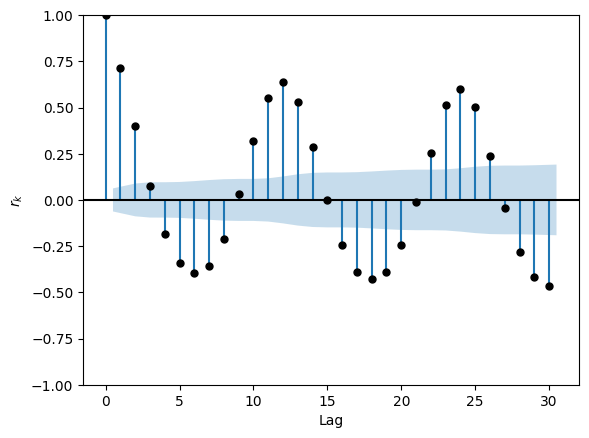

In [21]:
plot_acf(x=df['Furnas'], lags=30, color= 'k')
plt.ylabel(f'$r_k$')
plt.xlabel('Lag')
plt.title('')
plt.savefig(f'Autocorrelation - Furnas.png', format='png')
plt.show()

# Hurst

Coeficiente de Hurst = 0.572


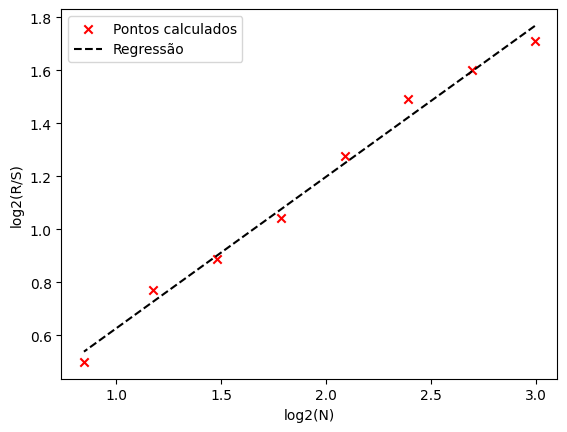

In [22]:
Hurst(df['Camargos_norm'].to_numpy(), name='Camargos')

Coeficiente de Hurst = 0.5843


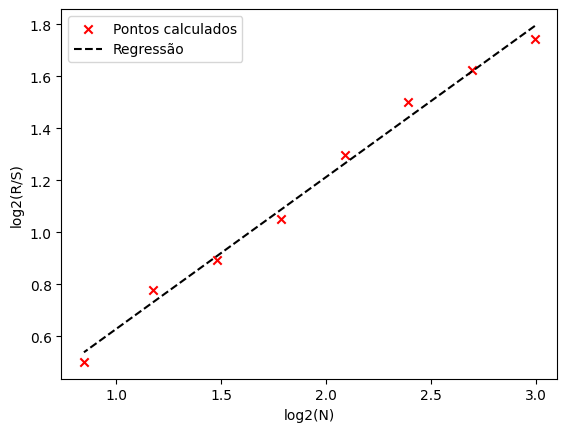

In [23]:
Hurst(df['Furnas_norm'].to_numpy(), name='Furnas')